In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import prepare, explore, modeling

# Predicting Programming Languages
### Linh Quach,  Robert Murphey,  Xavier Carter (August, 2021)

### Project Scope

### Executive Summary

-----

### Acquire

In [2]:
#utilizing json file created from acquire.py, using pandas read json to create a dataframe
df = pd.read_json('data2.json')

In [3]:
df.head()

,repo,language,readme_contents
0,IrisShaders/Iris,Java,![Iris: An open-source shaders mod compatible ...
1,returntocorp/semgrep,Java,"</br>\n<p align=""center"">\n <a href=""https:..."
2,CaffeineMC/sodium-fabric,Java,"<img src=""src/main/resources/assets/sodium/ico..."
3,keycloak/keycloak,Java,# Keycloak\n\nKeycloak is an Open Source Ident...
4,NationalSecurityAgency/ghidra,Java,"<img src=""Ghidra/Features/Base/src/main/resour..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             225 non-null    object
 1   language         225 non-null    object
 2   readme_contents  225 non-null    object
dtypes: object(3)
memory usage: 5.4+ KB


In [5]:
df.language.value_counts()

R             75
JavaScript    50
Python        50
Java          50
Name: language, dtype: int64

-----

To Do's:

1.) drop duplicates, drop null values

2.) lower case language and repo columns, and readme_contents as well.

3.) drop non alpha-numeric values.

4.) Drop words which are excessively long, appears there is combination of words

-----

### Prepare

In [6]:
#utilizing prepare function which will retrun a df containing original columns and columns which have been normalized, lemmatized, tokenized and had stopwords removed or added.
df = prepare.prep_repo_data(df)

In [7]:
df.head()

,repo_name,language,readme_contents,repo_name_cleaned,language_cleaned,readme_contents_cleaned
0,IrisShaders/Iris,Java,![Iris: An open-source shaders mod compatible ...,irisshadersiris,java,iris opensource shaders mod compatible optifin...
1,returntocorp/semgrep,Java,"</br>\n<p align=""center"">\n <a href=""https:...",returntocorpsemgrep,java,br p aligncenter hrefhttpssemgrepdevimg srchtt...
2,CaffeineMC/sodium-fabric,Java,"<img src=""src/main/resources/assets/sodium/ico...",caffeinemcsodiumfabric,java,img srcsrcmainresourcesassetssodiumiconpng wid...
3,keycloak/keycloak,Java,# Keycloak\n\nKeycloak is an Open Source Ident...,keycloakkeycloak,java,keycloak keycloak open source identity access ...
4,NationalSecurityAgency/ghidra,Java,"<img src=""Ghidra/Features/Base/src/main/resour...",nationalsecurityagencyghidra,java,img srcghidrafeaturesbasesrcmainresourcesimage...


-----

#### Feauture Engineering

In [8]:
#After brief examination, we realized in order to reduce noise
df['readme_contents_cleaned'] = df['readme_contents_cleaned'].str.findall('\w{1,18}').str.join(' ')

In [9]:
#Message Length and wordcounts for each read me
df['message_length'] = df.readme_contents_cleaned.apply(len)
df['word_count'] =  df.readme_contents_cleaned.str.split().apply(len)

-----

#### Split For Explore

In [10]:
train, validate, test = prepare.lang_split(df)
train.shape, validate.shape, test.shape

((97, 8), (42, 8), (35, 8))

### Explore

In [11]:
train.language.value_counts()

Python        26
JavaScript    26
Java          24
R             21
Name: language, dtype: int64

<AxesSubplot:xlabel='language', ylabel='Count'>

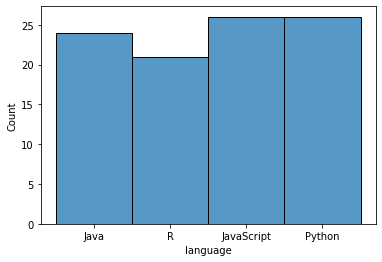

In [12]:
sns.histplot(train, x=train.language)

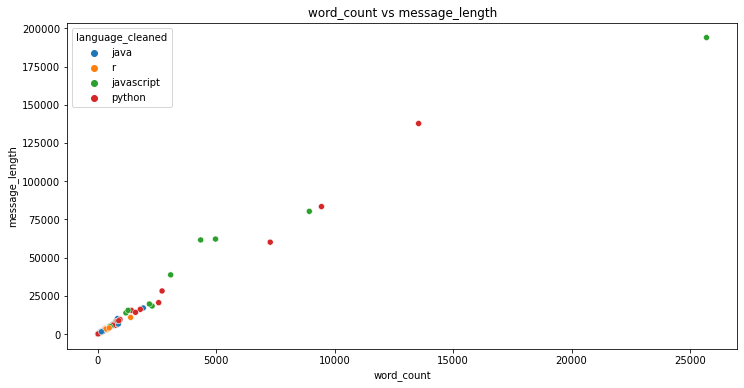

In [13]:
explore.show_scatter_plot(train, 'word_count', 'message_length', 'language_cleaned')

##### Takeaways
- Word count and message length mat play a role in the programming language used

In [14]:
# splitting the readmes into strings
java_read = ' '.join(train[train.language_cleaned == 'java'].readme_contents_cleaned)
python_read = ' '.join(train[train.language_cleaned == 'python'].readme_contents_cleaned)
r_read = ' '.join(train[train.language_cleaned == 'r'].readme_contents_cleaned)
javascript_read = ' '.join(train[train.language_cleaned == 'javascript'].readme_contents_cleaned)
all_content = ' '.join(train.readme_contents_cleaned)

In [15]:
#Counts as percent ratios
explore.show_counts_and_ratios(train, "language_cleaned")

,n,percent
python,26,0.268041
javascript,26,0.268041
java,24,0.247423
r,21,0.216495


In [16]:
#creating word frequencies
java_freq = pd.Series(java_read.split()).value_counts()
python_freq = pd.Series(python_read.split()).value_counts()
r_freq= pd.Series(r_read.split()).value_counts()
javascript_freq= pd.Series(javascript_read.split()).value_counts()
all_freq = pd.Series(all_content.split()).value_counts()

In [17]:
#Creating word counts table
word_table = (pd.concat([java_freq, python_freq, r_freq, javascript_freq, all_freq], axis=1, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
#naming the columns
word_table.columns = ['java', 'python', 'r', 'javascript', 'All']

In [18]:
#Creating list of words
java_words = re.sub(r'[^\w\s]', '', java_read).split()
r_words = re.sub(r'[^\w\s]', '', r_read).split()
python_words = re.sub(r'[^\w\s]', '', python_read).split()
javascript_words = re.sub(r'[^\w\s]', '', javascript_read).split()
all_content_words = re.sub(r'[^\w\s]', '', all_content).split()

### Frequency Graphs
- Top 20 words most common words used and what language is using them

#### Java

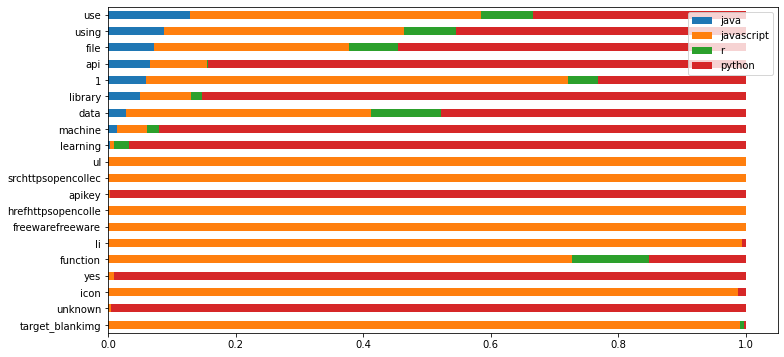

In [19]:
explore.show_distributions(word_table, orderby='java')

#### Javascript

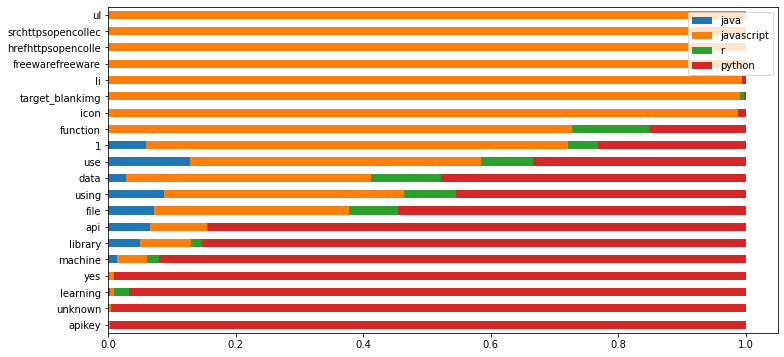

In [20]:
explore.show_distributions(word_table, orderby='javascript')

#### R

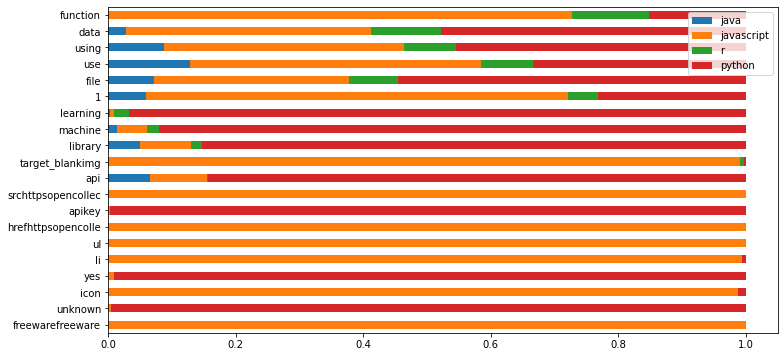

In [21]:
explore.show_distributions(word_table, orderby='r')

#### Python

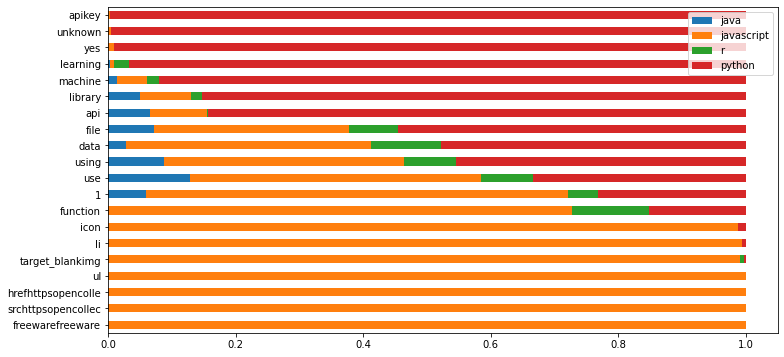

In [22]:
explore.show_distributions(word_table, orderby='python')

### WordClouds

#### Java 

-------------------
java
-------------------


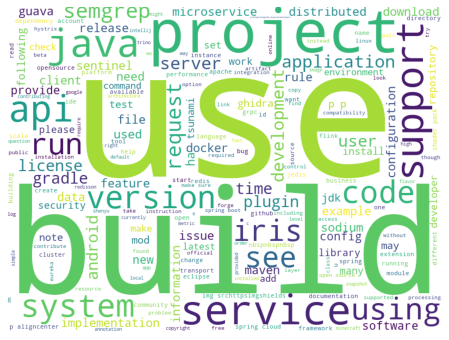

In [23]:
explore.df_to_wordcloud(train, 'java')

-------------------
javascript
-------------------


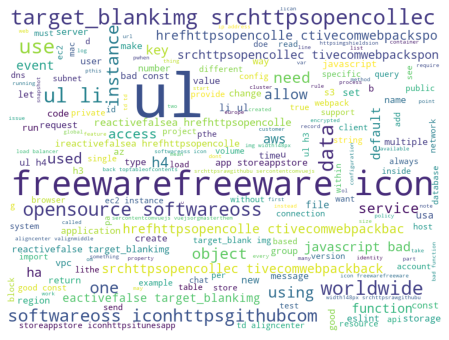

In [24]:
explore.df_to_wordcloud(train, 'javascript')

-------------------
r
-------------------


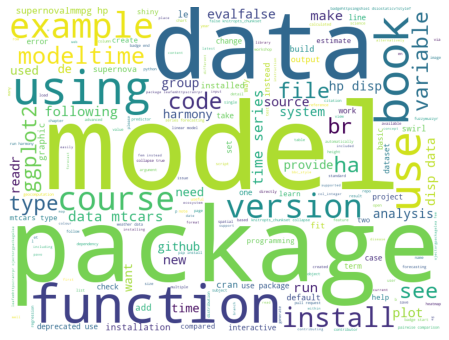

In [25]:
explore.df_to_wordcloud(train, 'r')

-------------------
python
-------------------


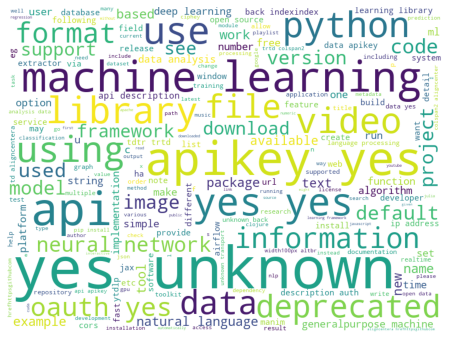

In [26]:
explore.df_to_wordcloud(train, 'python')

##### Bigrams

In [27]:
#top 20 bigrams for each language
top_20_bigrams_java = pd.Series(nltk.ngrams(java_read.split(), 2)).value_counts().head(20)
top_20_bigrams_javascript = pd.Series(nltk.ngrams(javascript_read.split(), 2)).value_counts().head(20)
top_20_bigrams_r = pd.Series(nltk.ngrams(r_read.split(), 2)).value_counts().head(20)
top_20_bigrams_python = pd.Series(nltk.ngrams(python_read.split(), 2)).value_counts().head(20)

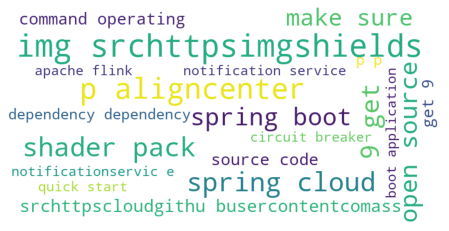

In [28]:
explore.bigrams_wordclouds(top_20_bigrams_java)

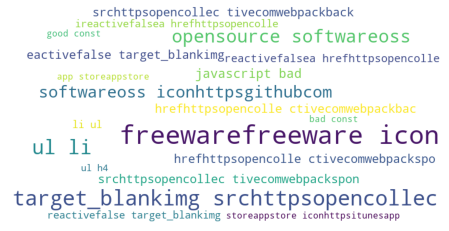

In [29]:
explore.bigrams_wordclouds(top_20_bigrams_javascript)

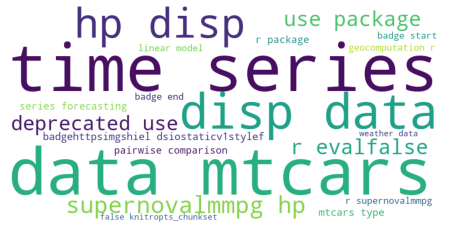

In [30]:
explore.bigrams_wordclouds(top_20_bigrams_r)

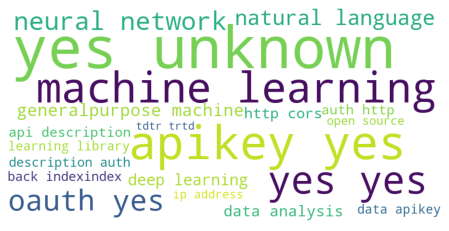

In [31]:
explore.bigrams_wordclouds(top_20_bigrams_python)

Trigrams

In [32]:
#top 20 trigrams for each language
top_20_trigrams_java = pd.Series(nltk.ngrams(java_read.split(), 3)).value_counts().head(20)
top_20_trigrams_javascript = pd.Series(nltk.ngrams(javascript_read.split(), 3)).value_counts().head(20)
top_20_trigrams_r = pd.Series(nltk.ngrams(r_read.split(), 3)).value_counts().head(20)
top_20_trigrams_python = pd.Series(nltk.ngrams(python_read.split(), 3)).value_counts().head(20)
                                                                                            

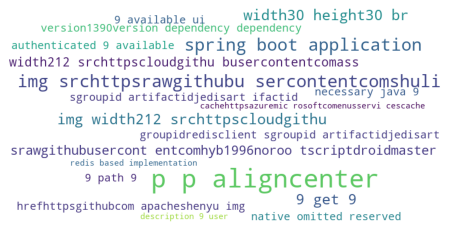

In [33]:
explore.trigrams_wordclouds(top_20_trigrams_java)

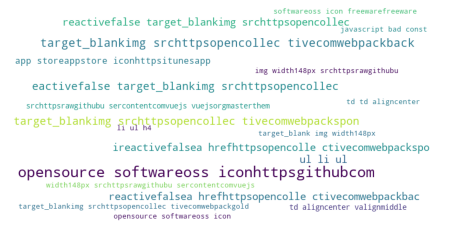

In [34]:
explore.trigrams_wordclouds(top_20_trigrams_javascript)

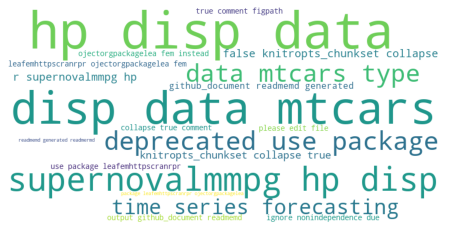

In [35]:
explore.trigrams_wordclouds(top_20_trigrams_r)

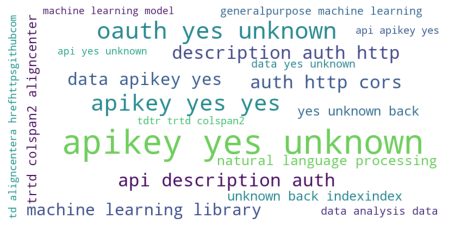

In [36]:
explore.trigrams_wordclouds(top_20_trigrams_python)

In [37]:
#most common words used
common = []
for i in all_content_words:
    if i in java_read:
        if i in javascript_read:
            if i in r_read:
                if i in python_read:
                    common.append(i)
common = ' '.join(common)


-------------------
Common Words
-------------------


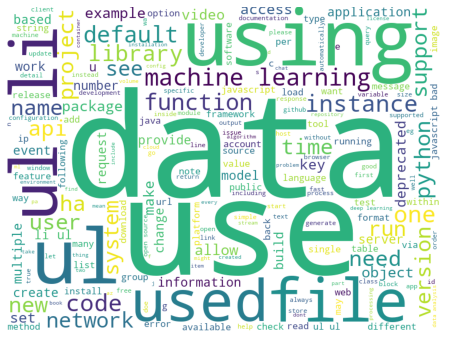

In [38]:
explore.word_cloud(common, 'Common Words')

### Modeling 
- For modeling , we will split our original dataframe into train validate and test

In [39]:
tfidf = TfidfVectorizer(stop_words = ['data','use'])
X =tfidf.fit_transform(df.readme_contents_cleaned)
y = df.language_cleaned

In [40]:
X_train, X_validate, y_train, y_validate, X_test, y_test = modeling.xy_split(X, y)

### Baseline 

In [41]:
modeling.get_baseline(train)

26.80400%


### Decision Tree

In [42]:
tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 7)
modeling.train_validate_results(tree, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 74.22680 %  | Validate model accuracy: 66.66667 % 
Train model Recall: 73.95833 %    | Validate model Recall: 65.36616 %
Train model Precision: 80.40675 % | Validate model Precision: 80.86957 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                java  javascript     python          r  accuracy  macro avg  \
precision   0.904762    0.547619   0.888889   0.875000  0.742268   0.804067   
recall      0.791667    0.884615   0.615385   0.666667  0.742268   0.739583   
f1-score    0.844444    0.676471   0.727273   0.756757  0.742268   0.751236   
support    24.000000   26.000000  26.000000  21.000000  0.742268  97.000000   

           weighted avg  
precision      0.798335  
recall         0.742268  
f1-score       0.749030  
support       97.000000  
------Validate Classification report-----
                java  javascript     python         r  accuracy  macr

### KNN

In [43]:
knn = KNeighborsClassifier(n_neighbors=(9))
modeling.train_validate_results(knn, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 79.38144 %  | Validate model accuracy: 78.57143 % 
Train model Recall: 80.23123 %    | Validate model Recall: 79.10354 %
Train model Precision: 81.66043 % | Validate model Precision: 82.29167 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                java  javascript     python          r  accuracy  macro avg  \
precision   0.718750    0.823529   0.724138   1.000000  0.793814   0.816604   
recall      0.958333    0.538462   0.807692   0.904762  0.793814   0.802312   
f1-score    0.821429    0.651163   0.763636   0.950000  0.793814   0.796557   
support    24.000000   26.000000  26.000000  21.000000  0.793814  97.000000   

           weighted avg  
precision      0.809169  
recall         0.793814  
f1-score       0.788135  
support       97.000000  
------Validate Classification report-----
                java  javascript  python         r  accuracy  macro a

### Logistic Regression

In [44]:
lm = LogisticRegression(C=1).fit(X_train, y_train)
modeling.train_validate_results(lm, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 100.00000 %  | Validate model accuracy: 71.42857 % 
Train model Recall: 100.00000 %    | Validate model Recall: 69.67172 %
Train model Precision: 100.00000 % | Validate model Precision: 78.72024 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
           java  javascript  python     r  accuracy  macro avg  weighted avg
precision   1.0         1.0     1.0   1.0       1.0        1.0           1.0
recall      1.0         1.0     1.0   1.0       1.0        1.0           1.0
f1-score    1.0         1.0     1.0   1.0       1.0        1.0           1.0
support    24.0        26.0    26.0  21.0       1.0       97.0          97.0
------Validate Classification report-----
                java  javascript     python         r  accuracy  macro avg  \
precision   0.857143    0.625000   0.666667  1.000000  0.714286   0.787202   
recall      0.600000    0.909091   0.833333  0.4444

### Random Forest

In [45]:
rf  = RandomForestClassifier(random_state=123, max_depth=3, min_samples_leaf=7)
modeling.train_validate_results(rf, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 76.28866 %  | Validate model accuracy: 38.09524 % 
Train model Recall: 74.50778 %    | Validate model Recall: 35.39141 %
Train model Precision: 83.67063 % | Validate model Precision: 55.76923 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                java  javascript     python          r  accuracy  macro avg  \
precision   0.950000    0.777778   0.619048   1.000000  0.762887   0.836706   
recall      0.791667    0.807692   1.000000   0.380952  0.762887   0.745078   
f1-score    0.863636    0.792453   0.764706   0.551724  0.762887   0.743130   
support    24.000000   26.000000  26.000000  21.000000  0.762887  97.000000   

           weighted avg  
precision      0.825953  
recall         0.762887  
f1-score       0.750511  
support       97.000000  
------Validate Classification report-----
                java  javascript     python         r  accuracy  macr

### Linear SVC

In [46]:
svc = LinearSVC(C=1.5)
modeling.train_validate_results(svc, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 100.00000 %  | Validate model accuracy: 83.33333 % 
Train model Recall: 100.00000 %    | Validate model Recall: 82.72727 %
Train model Precision: 100.00000 % | Validate model Precision: 86.19048 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
           java  javascript  python     r  accuracy  macro avg  weighted avg
precision   1.0         1.0     1.0   1.0       1.0        1.0           1.0
recall      1.0         1.0     1.0   1.0       1.0        1.0           1.0
f1-score    1.0         1.0     1.0   1.0       1.0        1.0           1.0
support    24.0        26.0    26.0  21.0       1.0       97.0          97.0
------Validate Classification report-----
           java  javascript     python         r  accuracy  macro avg  \
precision   0.9    0.714286   0.833333  1.000000  0.833333   0.861905   
recall      0.9    0.909091   0.833333  0.666667  0.833333   

### Naive Bayes

In [47]:
nb = MultinomialNB(alpha=.05)
modeling.train_validate_results(nb, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 100.00000 %  | Validate model accuracy: 73.80952 % 
Train model Recall: 100.00000 %    | Validate model Recall: 73.54798 %
Train model Precision: 100.00000 % | Validate model Precision: 77.66484 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
           java  javascript  python     r  accuracy  macro avg  weighted avg
precision   1.0         1.0     1.0   1.0       1.0        1.0           1.0
recall      1.0         1.0     1.0   1.0       1.0        1.0           1.0
f1-score    1.0         1.0     1.0   1.0       1.0        1.0           1.0
support    24.0        26.0    26.0  21.0       1.0       97.0          97.0
------Validate Classification report-----
                java  javascript     python         r  accuracy  macro avg  \
precision   0.714286    0.700000   0.692308  1.000000  0.738095   0.776648   
recall      1.000000    0.636364   0.750000  0.5555

## Best Model on Test 

In [48]:
modeling.test_results(knn, X_test, y_test , X_train, y_train,  details=True)

Test model Accuracy: 82.85714 %
Test model Recall: 82.84722 % 
Test model Precision: 83.92857 %
---------- More Details ------------
-----Test Classification report----
               java  javascript    python         r  accuracy  macro avg  \
precision  0.700000    1.000000  0.800000  0.857143  0.828571   0.839286   
recall     0.875000    0.800000  0.888889  0.750000  0.828571   0.828472   
f1-score   0.777778    0.888889  0.842105  0.800000  0.828571   0.827193   
support    8.000000   10.000000  9.000000  8.000000  0.828571  35.000000   

           weighted avg  
precision      0.847347  
recall         0.828571  
f1-score       0.831145  
support       35.000000  
-----Test Confusion Matrix------
            Java  Javascript  R  Python
Java           7           1  1       1
Javascript     0           8  0       0
R              0           1  8       1
Python         1           0  0       6
